# Wolff Algorithm and Broad Histogram method for 3D Heisenberg Model

## Packages

In [1]:
try:
    from tqdm.notebook import tqdm as tq
except:
    !pip install tqdm
    from tqdm.notebook import tqdm as tq

import numpy as np
from scipy import integrate
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns
import pandas as pd
from numba import prange
import time
from tqdm.notebook import tqdm as tq

rcParams.update({'font.size': 11.5})

# General functions

## Initilization and neighbors

In [60]:
@nb.njit
def random_initialize(L):
    """Generates a random initialization of the spins lattice.
    Args:
        L (int): Length of the lattice
    Returns:
        S (array): (L^3 x 3) array where each row represents a spin and each column contains
                    its components in x, y and z.
    """
    N = L**3
    S = np.zeros((N,3))
    PHI = np.random.uniform(0, 2*np.pi, N)
    THETA = np.random.uniform(0, np.pi, N)
    Sx = np.sin(THETA)*np.cos(PHI)
    Sy = np.sin(THETA)*np.sin(PHI)
    Sz = np.cos(THETA)
    S[:,0], S[:,1], S[:,2] = Sx, Sy, Sz 
    return S

def get_neighbors(L):
    """
    Args:
        L (int): Length of the lattice
    Returns:
        nbr (array): (L^3 x 6) array where each row represents a spin and each column the
                    the index of its neighbors.
    """
    N = L**3
    nbr = np.zeros((N,6),dtype=np.int32)
    for i in range(N):
        nbr[i,:] = [(i // L) * L + (i - 1) % L, (i // L) * L + (i + 1) % L,
               (i + L) % N, (i - L) % N, (i + L**2) % N, (i - L**2) % N]
    return nbr

def central_diff(Y, dx):
    n = Y.shape[0]
    dy_dx = np.zeros(n-2)
    for i in range(n-2):
        dy_dx[i] = (Y[i+2]-Y[i])/(2*dx)
    return dy_dx

In [3]:
@nb.njit
def Metropolis(S, nbr, T, n_flips):
    N = S.shape[0]
    for step in range(n_flips):       
        # Random vector r
        phi = np.random.uniform(0, 2*np.pi)
        z = np.random.uniform(-1,1)
        theta = np.arccos(z)
        r = np.array([np.sin(theta)*np.cos(phi),
                      np.sin(theta)*np.sin(phi),
                      np.cos(theta)])
        
        # Generate and flip cluster at site k
        k = np.random.randint(0, N)
        A_k = np.sum(S[nbr[k]],axis=0)
        Anorm = np.linalg.norm(A_k)
        S_k = S[k]
        # Calculate the old and new energy (assumin the flip is accepted):
        ek_old = -np.dot(S_k, A_k)
        S_k = S_k - 2*np.dot(S_k, r)*r
        ek_new = -np.dot(S_k, A_k)
        DeltaE = ek_new - ek_old
        p = np.exp(-DeltaE/T) # Probability of accepting the move
        if np.random.random() < p:
            S[k] = S_k # Accept the move with probability p
    return S

## Thermodynamic quantities

In [4]:
@nb.njit
def calculate_energy(S, nbr):
    """
    Args:
        S (array): Lattice
        nbr (array): Neighbors
    Returns:
        E (float): Energy
    """
    N = S.shape[0]
    E = 0
    for i in prange(N):
        nbrs_i = nbr[i]
        S_i = S[i]
        for ii in nbrs_i:
            E += -np.dot(S[ii], S_i)
    E = E/2
    return E

@nb.njit
def calculate_magnet(S):
    """
    Args:
        S (array): Lattice
    Returns:
        M (float): Magentization calculated as the norm of the sum of all spin vectors
    """
    N = S.shape[0]
    S_sum = np.sum(S, axis=0)
    return 1/N*np.linalg.norm(S_sum)

In [5]:
def test_calculate_energy(L):
    nbr = get_neighbors(L)
    S = random_initialize(L)
    E = calculate_energy(S, nbr)
    print('Energy1 = ', E)
    S = np.zeros((L**3,3))
    S[:,0] = 1
    E = calculate_energy(S, nbr)
    print('Energy2 =', E)

test_calculate_energy(10)

Energy1 =  -10.72443815499568
Energy2 = -3000.0


# Wolff Clusters Algorithm

In [6]:
@nb.njit
def p_acc(T, r, s_i, s_j):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    beta = 1/T
    p = 1-np.exp(min(0,-2*beta*(np.dot(r, s_i))*np.dot(r, s_j))) 
    return p

@nb.njit
def add_neighbors(neighbors, j, T, r, S, Pocket, Cluster):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    for ii in range(neighbors[j].shape[0]):
        l = int(neighbors[j][ii])
        p = p_acc(T, r, S[j,:], S[l,:])
        if (l not in Cluster) and np.random.random() < p:
            Pocket = np.append(Pocket, l)
            Cluster = np.append(Cluster, l)
    return Pocket, Cluster

@nb.njit
def generate_and_flip_cluster(S, neighbors, k, T, r):
    Pocket, Cluster = np.array([k], dtype=np.int32), np.array([k], dtype=np.int32)
    while Pocket.shape[0] != 0:
        index_j = np.random.randint(0, Pocket.shape[0])
        j = int(Pocket[index_j])
        Pocket, Cluster = add_neighbors(neighbors, j, T, r, S, Pocket, Cluster)
        Pocket = np.delete(Pocket, index_j)
    for i in Cluster:
        S[i] = S[i] - 2*np.dot(S[i], r)*r
    return S

@nb.njit
def cluster_sample(S, nbr, T, n_flips):
    N = S.shape[0] # Total number of spins
    # Generate cluster configuration with n_flips
    for step in range(n_flips):       
        # Random vector r
        phi = np.random.uniform(0, 2*np.pi)
        z = np.random.uniform(-1,1)
        theta = np.arccos(z)
        r = np.array([np.sin(theta)*np.cos(phi),
                      np.sin(theta)*np.sin(phi),
                      np.cos(theta)])
        
        # Generate and flip cluster at site k
        k = np.random.randint(0, N)
        S = generate_and_flip_cluster(S, nbr, k, T, r)
    return S

In [7]:
@nb.njit
def thermo_T(S, nbr, T, n_samples):
    """Calculates the thermodynamic quantities at a given temperature
    Args:
        S (array)
        nbr (array)
        T (float): Temperature > 0
        n_samples (int): Number of values to calculate
    Returns:
        M (float): Magnetization
    """
    M = 0
    n_flips = 200
    if T < 1.45:
        n_flips = 10
    for i in range(n_samples):
        S = cluster_sample(S, nbr, T, n_flips) 
        M += calculate_magnet(S)
    M = M/n_samples
    return M

In [8]:
n_temps = 40 # Number of temperature values 
T_vals = np.linspace(2.5, 0.5, n_temps)
M = np.zeros(n_temps)
L = 10
S = random_initialize(L)
nbr = get_neighbors(L)
t = tq(range(n_temps))
for ii in t:
    n_samples = 200 # Number n of samples for calculating the thermal average
    M[ii] = thermo_T(S, nbr, T_vals[ii], n_samples)
    t.set_description("T = {:.3f} : ".format(T_vals[ii]))

  0%|          | 0/40 [00:00<?, ?it/s]

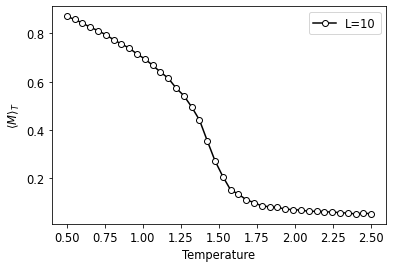

In [9]:
plt.plot(T_vals,M,'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle_T$')
plt.legend()
# plt.savefig('L_{}.jpg'.format(L), bbox_inches='tight')

# Broad Histogram Method

## Energize and rotate spin

In [10]:
@nb.njit
def get_angles(vector):
    """
    Args:
        vector (array)
    Returns:
        theta (float): Polar angle (z axis) 
        phi (float): Azimuth angle
    """
    r = np.linalg.norm(vector)
    x, y, z = vector[0], vector[1], vector[2]
    theta = np.arccos(z/r)
    if theta == 0:
        phi = 0
    else:
        phi = np.arccos(x/(r*np.sin(theta)))
        phi = np.arctan2(y,x)
    return theta, phi

In [11]:
def energize(S, nbr, E_target, tol, max_iter):
    """
    Args:
        S (array)
        nbr (array)
        E_target (float)
        tol (float)
        max_iter (int)
    Returns:
        S (array): Energized configuration
        E_current: Energy 
    """
    N = S.shape[0]
    iteration = 0
    E_current = calculate_energy(S, nbr)
    DeltaE = abs(E_target - E_current)
    while DeltaE > tol and iteration <= max_iter:
        # Choose a spin at random
        k = np.random.randint(0, N)
        S_k = S[k]
        # Calculate the local field of that spin
        A_k = np.sum(S[nbr[k]],axis=0)
        Anorm = np.linalg.norm(A_k)
        theta, phi = get_angles(A_k)
        # Make a rotation to align A_k with the z axis
        alpha = np.pi/2 - phi
        beta = -theta
        Rotz = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                        [np.sin(alpha), np.cos(alpha), 0],
                        [0, 0, 1]])
        Rotx = np.array([[1, 0, 0],
                        [0, np.cos(beta), np.sin(beta)],
                        [0, -np.sin(beta), np.cos(beta)]])
        Rot = np.dot(Rotx, Rotz)
        # Calculates the old energy
        ei_old = -np.dot(S_k, A_k)
        z = -ei_old/Anorm
        if E_current < E_target:
            z = np.random.uniform(-1, z)
        else:
            z = np.random.uniform(z, 1)
        theta = np.arccos(z)
        phi = np.random.uniform(0, 2*np.pi)
        # Get the new vector in spherical coordinates
        Sk_new = np.array([[np.sin(theta)*np.cos(phi)],
                           [np.sin(theta)*np.sin(phi)],
                           [np.cos(theta)]])
        # Rotate the new vector back to the original basis
        Sk_new = np.reshape(np.dot(Rot.T, Sk_new), A_k.shape)
        ei_new = - np.dot(Sk_new, A_k)
        S[k] = Sk_new
        DE = ei_new - ei_old
        # Calculate the new energy
        E_current += DE
        DeltaE = abs(E_target-E_current)
        iteration += 1
    return S, E_current

In [12]:
def test_energize(L, tol=0.01):
    print('Tolerance is ', tol)
    print('................................')
    for i in range(5):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        E_desired = np.random.uniform(-L**3, L**3)
        E_before = calculate_energy(S, nbr)
        print('E_before = ', E_before)
        S, E_after = energize(S, nbr, E_desired, tol, 20000)
        print('E_desired = ', E_desired)
        print('E_after = ', E_after)
        print('................................')
        
test_energize(10, 0.01)

Tolerance is  0.01
................................
E_before =  -7.1017474490301815
E_desired =  -121.48485818739107
E_after =  -121.48628241042664
................................
E_before =  -66.85270811573942
E_desired =  -34.4145619165854
E_after =  -34.42047484790825
................................
E_before =  -17.02084468412717
E_desired =  -50.15329633499039
E_after =  -50.149798888053624
................................
E_before =  -16.162582472400196
E_desired =  6.494077002973086
E_after =  6.4927839675908805
................................
E_before =  8.046020481725849
E_desired =  130.52866687559435
E_after =  130.5186820551021
................................


In [13]:
def rotate_spin(S, nbr, index, E, Emin, Emax, inplace=False):
    """
    Args:
        S (arary)
        nbr (array)
        index (int)
        E (float): Current energy of the configuration
        Emin (float): Minimun energy of the window
        Emax (float): Maximum energy of the window
    Returns:
        S (array)
        ei_old (float): Energy of the spin at given index. Needed for later.
        E (float): New energy
        Anorm (float): Magnitude of the local field of the spin at given index. Needed for later
    """
    N = S.shape[0]
    # Calculate the maximum possible window for rotating the spin such that the energy remains inside [Emin, Emax]
#     DeltaEb = min(Emax-E, E-Emin)
    DeltaEb_sup = Emax-E
    DeltaEb_inf = E-Emin
    S_i = S[index]
    nbr_i = nbr[index]
    # Local field A_i and norm
    A_i = np.sum(S[nbr_i],axis=0)
    Anorm = np.linalg.norm(A_i)
    theta, phi = get_angles(A_i)
    alpha = np.pi/2 - phi
    beta = -theta
    # Rotation matrix to get to basis where A_i is aligned with z axis
    Rotz = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                    [np.sin(alpha), np.cos(alpha), 0],
                    [0, 0, 1]])
    Rotx = np.array([[1, 0, 0],
                    [0, np.cos(beta), np.sin(beta)],
                    [0, -np.sin(beta), np.cos(beta)]])
    Rot = np.dot(Rotx, Rotz)
    ei_old = -np.dot(S_i, A_i)
    # Calculate the minimun and maximun values the energy of the spin i can have
    ei_min = ei_old - DeltaEb_inf
    ei_max = ei_old + DeltaEb_sup
    zmin = max(-1, -ei_max/Anorm) # These conditions ensure that z is always between [-1, 1].
    zmax = min(1, -ei_min/Anorm)
    zrand = np.random.uniform(zmin, zmax)
    theta = np.arccos(zrand)
    phi_rand = np.random.uniform(0, 2*np.pi)
    si_new = np.array([[np.sin(theta)*np.cos(phi_rand)],
                       [np.sin(theta)*np.sin(phi_rand)],
                       [np.cos(theta)]])
    # Get si_new back to old basis
    si_new = np.reshape(np.dot(Rot.T, si_new), A_i.shape)
    ei_new = -np.dot(si_new, A_i)
    if inplace:
        S[index] = si_new
    DeltaE = ei_new - ei_old
    E += DeltaE    # Update the energy
    return S, ei_old, E, Anorm

In [14]:
def test_rotate_spin(L, Num):
    for i in range(Num):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        N = S.shape[0]
        index = np.random.randint(0,N)
        DeltaEb = 2
        E_ini = calculate_energy(S, nbr)
        Emin = E_ini - DeltaEb
        Emax = E_ini + DeltaEb
        print('Emax =', Emax)
        print('Emin =', Emin)
        print('E_initial =', E_ini)
        num_true = 0
        E = E_ini
        for i in range(100):
            S, _, E, _ = rotate_spin(S, nbr, index, E, Emin, Emax, inplace=True)
            Efin = calculate_energy(S, nbr)
            num_true += Emin < Efin and Efin < Emax  
        print('E_final =', calculate_energy(S, nbr))
        print('Num_true out (/100) =', num_true)
        print('.............................................')
        
test_rotate_spin(10, 5)

Emax = -41.821772291453854
Emin = -45.821772291453854
E_initial = -43.821772291453854
E_final = -44.96497865561493
Num_true out (/100) = 100
.............................................
Emax = 26.20592868727598
Emin = 22.20592868727598
E_initial = 24.20592868727598
E_final = 22.83985310699655
Num_true out (/100) = 100
.............................................
Emax = -24.1811249111475
Emin = -28.1811249111475
E_initial = -26.1811249111475
E_final = -26.463709634705445
Num_true out (/100) = 100
.............................................
Emax = 32.029297327409324
Emin = 28.02929732740932
E_initial = 30.02929732740932
E_final = 31.6318559803668
Num_true out (/100) = 100
.............................................
Emax = 51.33623149516806
Emin = 47.33623149516806
E_initial = 49.33623149516806
E_final = 47.947837578641476
Num_true out (/100) = 100
.............................................


## Sampling

In [15]:
def one_energy(S, nbr, E_iter, DeltaEb, DeltaE_fix, num_samples = 60):
    """Calculate everything for a given energy at some T and E
    Args:
        S (array): Array of spins size (Nx3).
        nbr (array): Array containig the indices of the neighbors of each spin.
        E (float): Energy of interest.
        DeltaEb (float): Window for rotating the spins.
        DeltaE_fix (float): Fixed number for obtaining the N_up, N_down values.
        shuffle (bool): Random lattice sweep.
    Returns:
        N_up (float): Updated
        N_down (float): Updated
        Thermo (dict): Updated
    """
    N = S.shape[0]
    Thermo = np.zeros(4)
    magnetization = 0
    indices = np.arange(N)
    indices_shuffle = indices.copy()
    N_up = 0
    N_down = 0
    Emin = E_iter - DeltaEb # Define limits of energy for each window
    Emax = E_iter + DeltaEb
    E_current = calculate_energy(S, nbr)
    for n in range(num_samples):
        for i in range(N):
            index = indices[i]
            S, ei_old, _, Ai_norm = rotate_spin(S, nbr, index, E_current, Emin, Emax) # Rotate the spin at given index
            # Calculate N_up and N_down (refer to PhD. theis of prof. JD page 61)
            if abs(DeltaE_fix + ei_old) < Ai_norm:
                N_up += 1/N * 1/(2*Ai_norm)
            if abs(-DeltaE_fix + ei_old) < Ai_norm:
                N_down += 1/N * 1/(2*Ai_norm)
        magnetization += calculate_magnet(S)
        # Generate an uncorrelated config for the next sample
        #S = random_initialize(L)
        np.random.shuffle(indices_shuffle)
        for index in indices_shuffle:
            S, _, E_current, _ = rotate_spin(S, nbr, index, E_current, Emin, Emax, inplace=True)
    N_up = N_up/num_samples
    N_down = N_down/num_samples
    Thermo[0] = magnetization/num_samples # Microcanonical average
    return N_up, N_down, Thermo

In [16]:
def main_BHM(L, nbr, E_vals, DeltaEb, DeltaE_fix, num_samples):
    """Samples across all energies in a given array.
    Args:
        L (int)
        E_vals (array)
        DeltaEb (float)
        DeltaE_fix (float)
        nbr (array)
    Returns:
        Nup (Array)
        Ndown (Array)
        Thermo (Array)
    """
    num_energies =  E_vals.shape[0]
    Nup = np.zeros(num_energies)
    Ndown = np.zeros(num_energies)
    range_energies = tq(range(num_energies))
    Thermo = np.zeros((num_energies, 4))
    for ii in range_energies:
        energy = E_vals[ii]
        range_energies.set_description('E = {:.2f}'.format(energy))
        S = random_initialize(L)
        S = cluster_sample(S, nbr, 1.44, 600)
        # Generate a configuration whose energy falls inside the next window
        S, E_start = energize(S, nbr, energy, DeltaEb/5, 30000)
        Nup[ii], Ndown[ii], Thermo[ii] = one_energy(S, nbr, energy, DeltaEb, DeltaE_fix, num_samples)
    return Nup, Ndown, Thermo

## Main loop

In [92]:
L = 10
nbr = get_neighbors(L)

num_energies = 120
E_vals = np.linspace(-2700, 0, num_energies, endpoint=False)
dE = E_vals[1]-E_vals[0]
Nup = np.zeros(num_energies)
Ndown = np.zeros(num_energies)

DeltaEb = 2
DeltaE_fix = 1
num_samples = 200

Nup, Ndown, Thermo = main_BHM(L, nbr, E_vals, DeltaEb, DeltaE_fix, num_samples)

  0%|          | 0/120 [00:00<?, ?it/s]

In [93]:
beta = 1/DeltaE_fix * np.log(Nup/Ndown)
E_vals = np.linspace(-2700, 0, num_energies, endpoint=False)
def DoS(E_vals, beta):
    """
    Args:
        beta
    Returns:
        DoS (array): Density of states / DoS at E0
    """
    num_energies = E_vals.shape[0]
    entropy = np.zeros(num_energies)
    for i in range(num_energies):
        entropy[i] = integrate.trapezoid(beta[:i+1], E_vals[:i+1])
    return entropy
entropy = DoS(E_vals, beta)

# Plotting

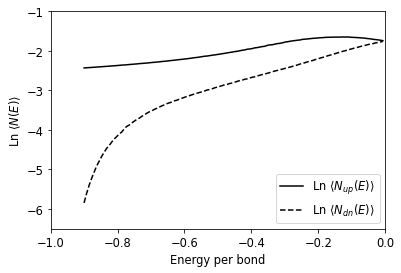

In [101]:
plt.plot(E_vals/3000, np.log(Nup),'k-', label=r'Ln $\langle N_{up}(E)\rangle$')
plt.plot(E_vals/3000, np.log(Ndown),'k--', label=r'Ln $\langle N_{dn}(E)\rangle$')
plt.ylabel(r'Ln $\langle N(E)\rangle$')
plt.xlabel(r'Energy per bond')
plt.ylim([-6.5, -1])
plt.xlim([-1, 0])
plt.legend(loc='lower right')
# plt.savefig('Log.jpg',bbox_inches='tight')

Text(0, 0.5, '$\\beta(E)$')

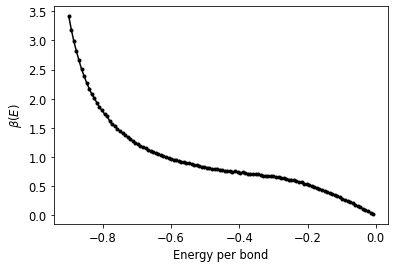

In [102]:
beta = 1/DeltaE_fix * np.log(Nup/Ndown)
plt.plot(E_vals/3000, beta,'k.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$\beta(E)$')
# plt.savefig('beta.jpg',dpi=400,bbox_inches='tight')

Text(0, 0.5, '$S = \\ln g(E)$')

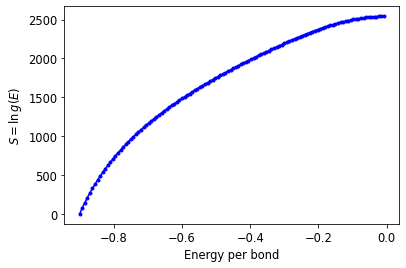

In [103]:
plt.plot(E_vals/3000, entropy,'b.-')
plt.xlabel(r'Energy per bond')
plt.ylabel(r'$S = \ln g(E)$')

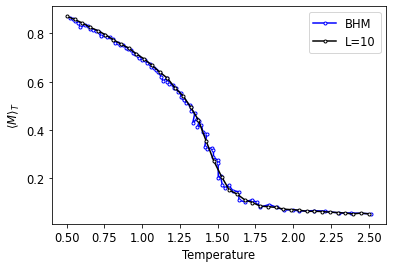

In [107]:
T = 1/beta
vals = (T >= 0.5) & (T <= 2.52)
T = T[vals]
M_BHM = Thermo[:,0]
M_BHM = M_BHM[vals]
plt.plot(T, M_BHM,'b.-',mfc='w',label="BHM")
plt.plot(T_vals,M,'k.-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle_T$')
plt.legend()